### paintype classification and visualisation

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score, roc_auc_score

In [3]:
from compare_paintype import make_data_paintype
from compare_hyperparams import load_feats, feature_importance, load_modZ_multi, load_cv, top_mods, print_clf_table
from compare_bfl_qsidp import load_qscode, match_question, proc_qsidp

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [4]:
import sklearn
print(sklearn.__version__)

0.24.2


In [5]:
import optuna
print(optuna.__version__)

2.9.1


#### dev

In [6]:
lb = pd.read_csv('labels_full/label_patients_pain.csv')

In [10]:
lb[['irritable bowel syndrome', 'migraine', 'back pain', 'osteoarthritis']].sum(axis=1).value_counts()

1    1952
2     372
0     328
3      68
4       4
dtype: int64

In [16]:
lb_pain = lb[lb[['irritable bowel syndrome', 'migraine', 'back pain', 'osteoarthritis']].sum(axis=1)!=0]

In [19]:
lb_pain.to_csv('labels_full/label_patients_4types.csv', index=None)

In [20]:
lb_pain[['irritable bowel syndrome', 'migraine', 'back pain', 'osteoarthritis']].sum(axis=1).value_counts()

1    1952
2     372
3      68
4       4
dtype: int64

In [21]:
lb_pain.sum()

eid                         8423692883
irritable bowel syndrome           481
migraine                           629
back pain                          598
osteoarthritis                    1208
bmrc                        8441006945
dtype: int64

In [26]:
lb_pain['bmrc'].rename('eid').to_csv('bmrc_full/subjs_paintype.csv', index=None)

### load cv results

In [6]:
curr_dir = '/well/seymour/users/uhu195/python/extract_npy'
cv_dir = os.path.join(curr_dir, 'cv_results', 'paintype')

In [7]:
df = load_cv(cv_dir).reset_index()

   max_depth  n_estimators  max_features  min_samples_split  min_samples_leaf  \
0          2           200      0.467359                 13                 1   
1          2           175      0.844838                 14                10   
2          6           175      0.610862                  6                13   
3         16           150      0.825022                 11                11   
4          2           200      0.620172                  6                 8   

   max_samples  balanced_accuracy   roc_auc  bestIC               qsidp  
0     0.972667           0.289195  0.552863     500                None  
1     0.800194           0.322034  0.568962     500          ['t1vols']  
2     0.879181           0.302966  0.567129     500  ['subcorticalvol']  
3     0.677255           0.313559  0.570047     500            ['fast']  
4     0.603097           0.304555  0.563455     500          ['t2star']  


In [8]:
df.shape

(591, 11)

In [9]:
df.iloc[df['balanced_accuracy'].argmax()]

index                                                       11
max_depth                                                    4
n_estimators                                               125
max_features                                          0.603653
min_samples_split                                            8
min_samples_leaf                                            12
max_samples                                           0.741283
balanced_accuracy                                     0.372352
roc_auc                                               0.602889
bestIC                                                     200
qsidp                ['cognitive', 'demographic', 'lifestyle']
Name: 154, dtype: object

In [10]:
print_clf_table(df, n=3)

\begin{tabular}{lrrr}
\toprule
                          Feature items &  Imaging components &  Balanced accuracy &  ROC AUC \\
\midrule
'cognitive', 'demographic', 'lifestyle' &                 200 &              0.372 &    0.603 \\
   'cognitive', 'demographic', 'mental' &                 100 &              0.372 &    0.603 \\
                'demographic', 'mental' &                  50 &              0.371 &    0.620 \\
\bottomrule
\end{tabular}



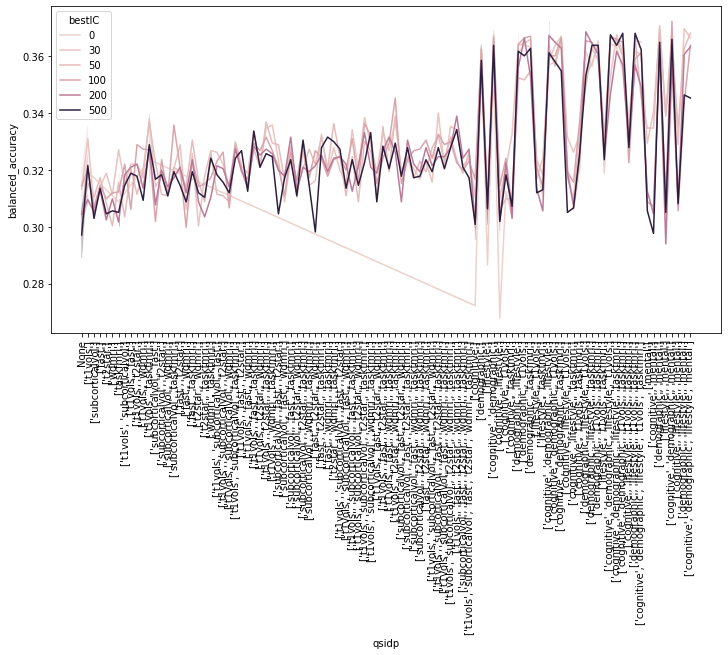

In [11]:
df_plot = df[['balanced_accuracy', 'bestIC', 'qsidp']]
fig, ax = plt.subplots(figsize=(12, 6))
_ = sns.lineplot(data=df_plot, x='qsidp', y='balanced_accuracy', hue='bestIC', ax=ax)
_ = plt.xticks(rotation=90)

#### retrain

In [12]:
bestIC = 200
qs_ls = ['cognitive', 'demographic', 'lifestyle']
# qs_ls = ['cognitive', 'demographic']
idp_ls = None
# idp_ls = ['taskfmri']

In [13]:
bp = df.iloc[df['balanced_accuracy'].argmax()].to_dict()

In [14]:
for i in ['balanced_accuracy', 'roc_auc', 'bestIC', 'qsidp', 'index']:
    del bp[i]

In [15]:
bp

{'max_depth': 4,
 'n_estimators': 125,
 'max_features': 0.6036526471380582,
 'min_samples_split': 8,
 'min_samples_leaf': 12,
 'max_samples': 0.741283441988088}

In [16]:
# load bfl
df_bfl_qsidp = make_data_paintype(bestIC=bestIC, qs_ls=qs_ls, idp_ls=idp_ls)
# retrain params
X_train, y_train, X_valid, y_valid = load_feats(df_bfl_qsidp, test_size=0.25, dummies=False,
                              train=True, balance=True, scaler=True)

/gpfs3/well/seymour/users/uhu195/python/extract-py3.7.4-skylake/lib/python3.7/site-packages/ipykernel_launcher.py:2: DtypeWarning: Columns (863,867) have mixed types.Specify dtype option on import or set low_memory=False.
  


df_qs_imputed_dum shape=(2396, 74)
df_bfl_qsidp shape=(2396, 279)
(2396, 273)


In [57]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(**bp, random_state=1)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=4, max_features=0.6036526471380582,
                       max_samples=0.741283441988088, min_samples_leaf=12,
                       min_samples_split=8, n_estimators=125, random_state=1)

In [58]:
preds = clf.predict(X_train)
print(len(preds))
print(balanced_accuracy_score(y_train, preds))
print(sum(y_train==preds)/len(y_train))

1416
0.5134180790960452
0.5134180790960452


In [59]:
preds = clf.predict(X_valid)
print(len(preds))
print(balanced_accuracy_score(y_valid, preds))
print(sum(y_valid==preds)/len(y_valid))

472
0.3389830508474576
0.3389830508474576


In [60]:
roc_auc_score(y_valid, clf.predict_proba(X_valid), multi_class='ovr')

0.5792576366944365

In [61]:
output_ls = ['irritable bowel syndrome', 'back pain', 'osteoarthritis', 'migraine', 'eid', 'bmrc']
tmp = df_bfl_qsidp.drop(columns=output_ls)
feature_names = tmp.columns

In [62]:
feat_importances = pd.Series(clf.feature_importances_, index=feature_names)

In [63]:
feat_sorted = feat_importances.sort_values(ascending=False)

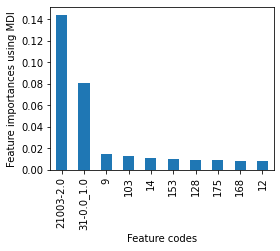

In [64]:
fig, ax = plt.subplots(figsize=(4,3))
feat_sorted.iloc[:10].plot.bar(ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
ax.set_ylabel('Feature importances using MDI')
ax.set_xlabel('Feature codes')
plt.savefig('figs/paintype_featureimportance.png', bbox_inches='tight', dpi=200)

In [65]:
feats10 = feat_sorted.iloc[:10].index
match_question(feats10)

[array(['Age when attended assessment centre'], dtype=object),
 array(['Sex'], dtype=object)]

#### visualising top feature

In [66]:
data_dir = '/well/seymour/users/uhu195/python/pain/output_patients_exmult_500//Result_IC200/'

top feature: 9


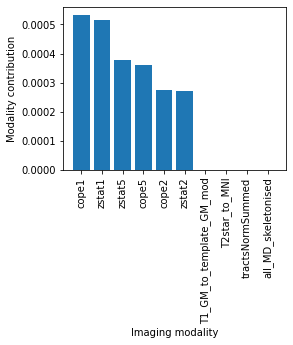

In [67]:
top_feat, mod_ls = top_mods(data_dir, top_feat=9, mod_num=10)
plt.savefig('figs/paintype_contribution.png', bbox_inches='tight', dpi=200)

(228453, 200)
(228453, 200)
(228453, 200)
(228453, 200)


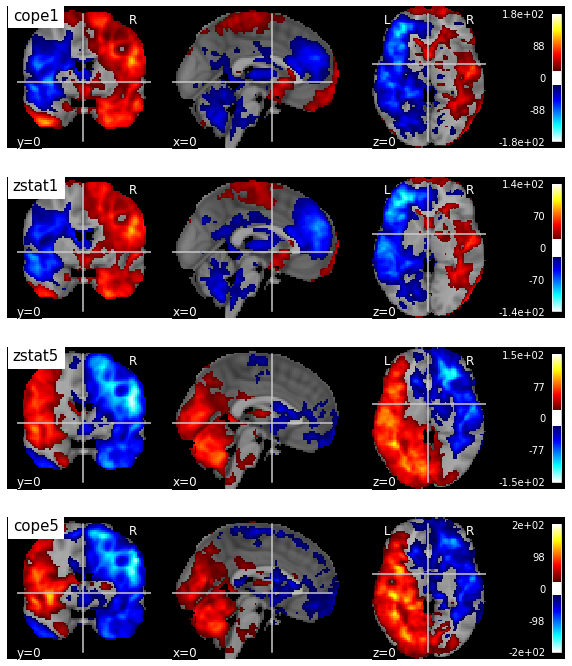

In [56]:
load_modZ_multi(data_dir, modality_ls=mod_ls, feature_num=top_feat, 
                plot_threshold=20, save_name='paintype_bfl.png')

modality 8
(228453, 200)
modality 44
(228453, 200)
modality 40
(228453, 200)
modality 34
(228453, 200)
modality 37
(228453, 200)


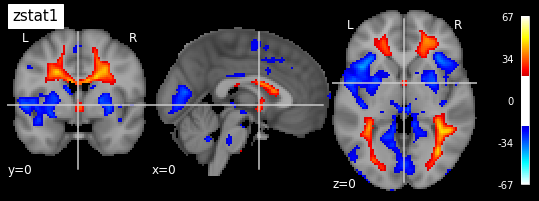

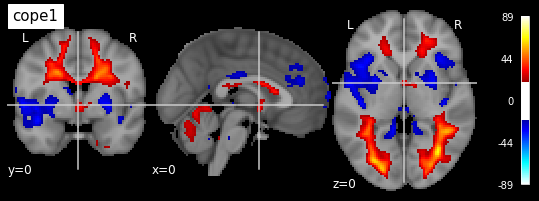

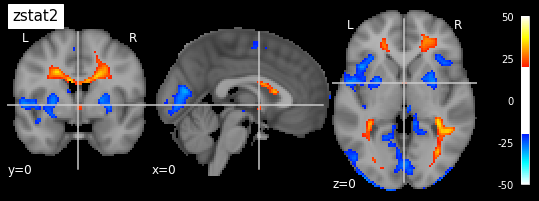

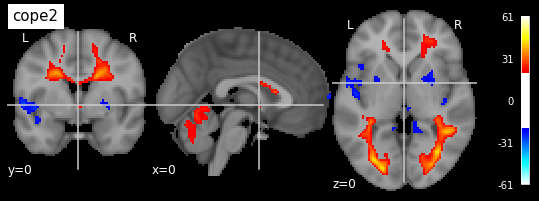

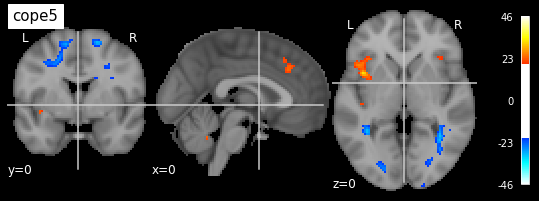

In [81]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=20)

top feature: 24
top modalities    modalities
43     zstat5
44      cope1
8      zstat1
34      cope2
40     zstat2


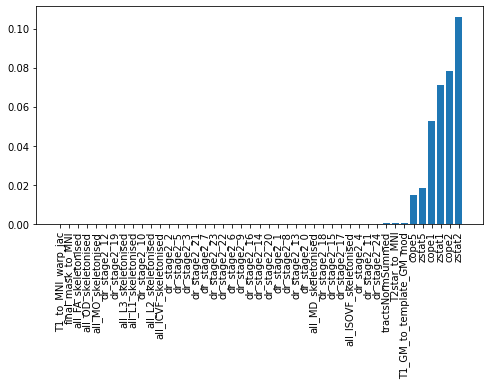

In [82]:
top_feat, mod_ls = top_mods(data_dir, top_feat=24, mod_num=5)

modality 40
(228453, 200)
modality 34
(228453, 200)
modality 8
(228453, 200)
modality 44
(228453, 200)
modality 43
(228453, 200)


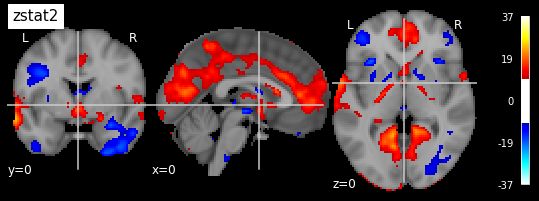

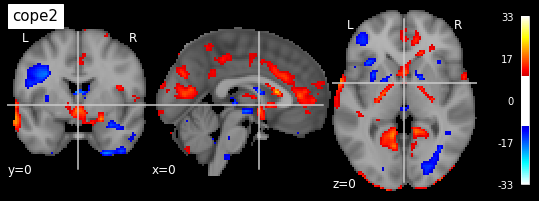

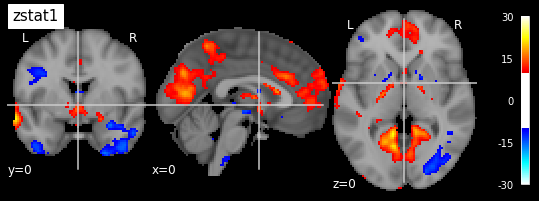

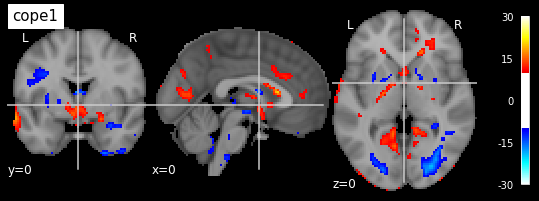

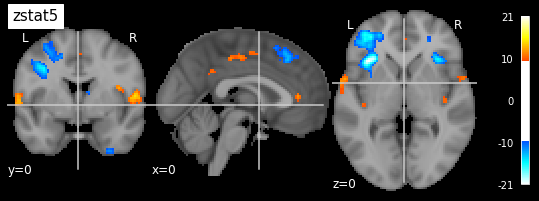

In [85]:
for mod in mod_ls:
    print(f'modality {mod}')
    reshape_z, mask_path = load_modZ(data_dir, modality_num=mod, feature_num=top_feat, plot_threshold=10)